In [ ]:
import os
import struct
import numpy
from matplotlib import pyplot as plt
import math
import json
import matplotlib.patches as mpatches
import pickle

### Utility Functions

In [ ]:
## get (time,value) tuple for a specific range
def get_range(t, v, t0, t1):
    idx_0 = 0
    idx_1 = 0
    t_len = len(t)
    for i in range(len(t)):
        if t[i]>=t0:
            idx_0=i
            break
    for i in range(idx_1+1,len(t)):
        if t[i]>=t1:
            idx_1=i
            break
    y_in_time_range =v[idx_0:idx_1] #[y_val for y_val, time_val in zip(v, t) if t0 <= time_val <= t1]
    t_in_time_range = t[idx_0:idx_1]#[time_val for time_val in t if t0 <= time_val <= t1]
    return (t_in_time_range, y_in_time_range)


## plot a specific range
def plot_range(t, v, t0, t1):
    t_vals, v_vals = get_range(t, v, t0, t1)
    plt.figure()
    plt.plot(t_vals, v_vals)


## plot acceleration, gyroscope and pressure
def full_plot_new(data_points, t0, t1, show: bool):

    # acc_factor = 16/(2**15-1)
    # gyr_factor = 2000/(2**15-1)
    # pre_factor = 40/16000000
    # ## separate measurements
    t= data_points['time']
    acc_x = data_points['acc_x']
    acc_y = data_points['acc_y']
    acc_z = data_points['acc_z']

    gyr_x = data_points['gyr_x']
    gyr_y = data_points['gyr_y']
    gyr_z = data_points['gyr_z']
    pressure= data_points['pressure']
    # pressure values with some correction

    acc_x = get_range(t, acc_x, t0, t1)
    acc_y = get_range(t, acc_y, t0, t1)
    acc_z = get_range(t, acc_z, t0, t1)

    gyr_x = get_range(t, gyr_x, t0, t1)
    gyr_y = get_range(t, gyr_y, t0, t1)
    gyr_z = get_range(t, gyr_z, t0, t1)

    pres = get_range(t, pressure, t0, t1)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    ## plot 3-axis acceleration
    # axs[0].plot(acc_x[0], acc_x[1], acc_y[0], acc_y[1], acc_z[0], acc_z[1])
    axs[0].plot(acc_x[0], acc_x[1], label='X-axis')
    axs[0].plot(acc_y[0], acc_y[1], label='Y-axis')
    axs[0].plot(acc_z[0], acc_z[1], label='Z-axis')
    axs[0].set_title("Acceleration(in g)")
    axs[0].legend(loc='upper right')

    ## plot 3-axis gyroscope
    axs[1].plot(gyr_x[0], gyr_x[1], label='X-axis')
    axs[1].plot(gyr_y[0], gyr_y[1], label='Y-axis')
    axs[1].plot(gyr_z[0], gyr_z[1], label='Z-axis')
    axs[1].set_title("Gyroscope(in deg/s)")
    axs[1].legend(loc='upper right')
    # axs[1].plot(gyr_x[0], gyr_x[1], gyr_y[0], gyr_y[1], gyr_z[0], gyr_z[1])
    # axs[1].set_title("Gyroscope")

    ## plot 3-axis pressure
    axs[2].plot(pres[0], pres[1])
    axs[2].set_title("Relative Pressure")

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    if show:
        plt.show()


def read_labels(labels_filename):
    with open(labels_filename, "r") as file:
        labeling = json.load(file)
        return labeling

In [ ]:
def find_absolute(x_component:list,y_component:list,z_component:list)->list[float]:
    nsamples = len(x_component)
    result = []
    for i in range(nsamples):
        result.append(math.sqrt(x_component[i]**2+y_component[i]**2+z_component[i]**2))
    return result

def moving_average(samples:list,window_size:int)->list[float]:
    ##padding
    new_list = numpy.zeros(shape=(1,window_size//2+1)).tolist()[0]
    new_list+=samples
    new_list+=numpy.zeros(shape=(1,window_size//2+1)).tolist()[0]
    kernel = (numpy.ones((1,window_size))/window_size).tolist()[0]
    average_result = numpy.convolve(new_list,kernel)
    return average_result[window_size:-window_size]

def average_plot_new(data_points, t0, t1, window_size,show: bool):


    t= data_points['time']
    acc_x = get_range(t,data_points['acc_x'],t0,t1)
    acc_y = get_range(t,data_points['acc_y'],t0,t1)
    acc_z = get_range(t,data_points['acc_z'],t0,t1)

    gyr_x = get_range(t,data_points['gyr_x'],t0,t1)
    gyr_y = get_range(t,data_points['gyr_y'],t0,t1)
    gyr_z = get_range(t,data_points['gyr_z'],t0,t1)
    pres= get_range(t,data_points['pressure'],t0,t1)


    acc = moving_average(find_absolute(acc_x[1],acc_y[1],acc_z[1]),window_size)
    gyr = moving_average(find_absolute(gyr_x[1],gyr_y[1],gyr_z[1]),window_size)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].plot(acc_x[0],acc,label='Acc Magnitude')
    axs[0].set_title("Acceleration(in g)")
    axs[0].legend(loc='upper right')

    axs[1].plot(gyr_x[0],gyr,label='Gyr Magnitude')
    axs[1].set_title("Gyroscope(in deg/s)")
    axs[1].legend(loc='upper right')
    # axs[1].plot(gyr_x[0], gyr_x[1], gyr_y[0], gyr_y[1], gyr_z[0], gyr_z[1])
    # axs[1].set_title("Gyroscope")

    ## plot 3-axis pressure
    axs[2].plot(pres[0], pres[1])
    axs[2].set_title("Relative Pressure")

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    if show==True:
        plt.show()
    return axs

#find the index of closest sample to t0
def find_closest_sample(t_samples,t0):
    idx = 0
    closest=1000
    for i in range(len(t_samples)):
        tmp=abs(t0-t_samples[i])
        if tmp<closest:
            closest = tmp
            idx = i
    return idx
#plot range of sample will their corresponding label on a subplot
def plot_and_label(figure,t,data_points,t_min,t_max,plot_label,labeling_data):
    t_min_sample = find_closest_sample(t,t_min)
    t_max_sample = find_closest_sample(t,t_max)

    figure.plot(t[t_min_sample:t_max_sample],data_points[t_min_sample:t_max_sample])
    figure.set_title(plot_label)
    for label in labeling_data:
        t0,t1,lab = label
        if t1<t_min or t0>t_max:
            continue
        #print(t0,t1,lab)

        if lab == 'HitAndFalling':
            figure.axvspan(max(t0,t_min),min(t1,t_max),color = 'red',alpha=0.2)
        # if lab == 'HitNoFalling':
        #     figure.axvspan(max(t0,t_min),min(t1,t_max),color = 'green',alpha=0.2)

    #legend_patches = [mpatches.Patch(color='white',alpha=0.2,label ='No Fall'),mpatches.Patch(color='red',alpha=0.2,label ='Fall')]
    legend_patches = [mpatches.Patch(color='red',alpha=0.2,label ='Fall')]
    figure.legend(handles=legend_patches)


In [ ]:
measurements_pickle = "labeled_fall_detection_data.pkl"
labels_filename = "all_Labels.json"

all_data = pickle.load(open(measurements_pickle,'rb'))
data_labels = read_labels(labels_filename)


## Visualization

## Plot all data between 0s and 30s

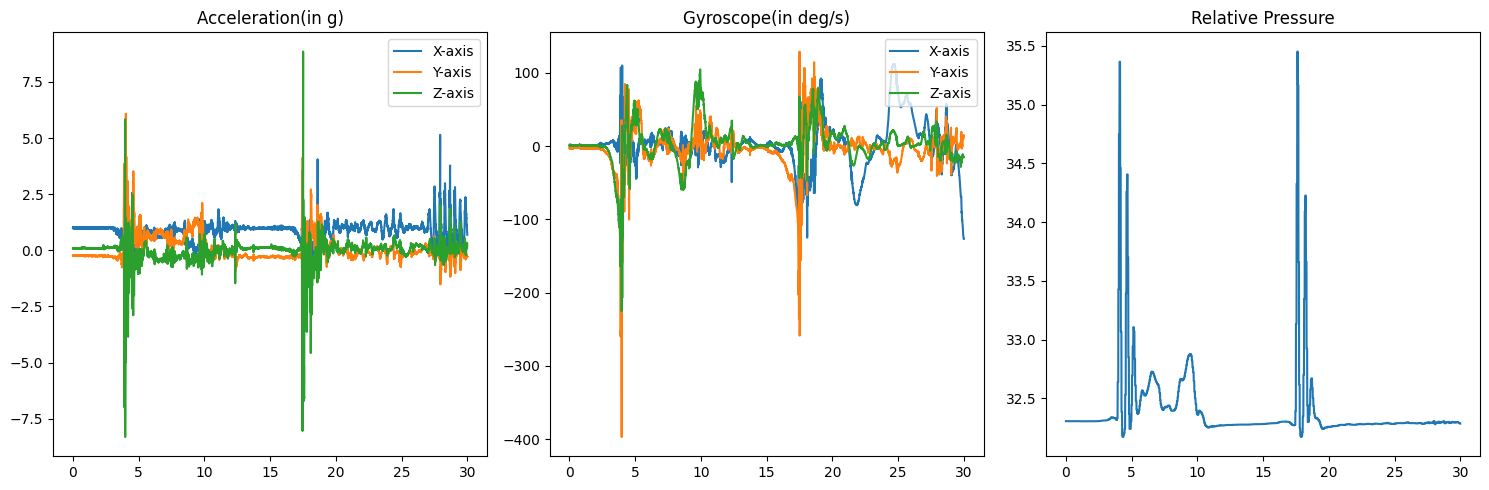

In [ ]:
full_plot_new(all_data,0,30,True)

## Plot a moving average of data between 0s and 30s with windows size of 11

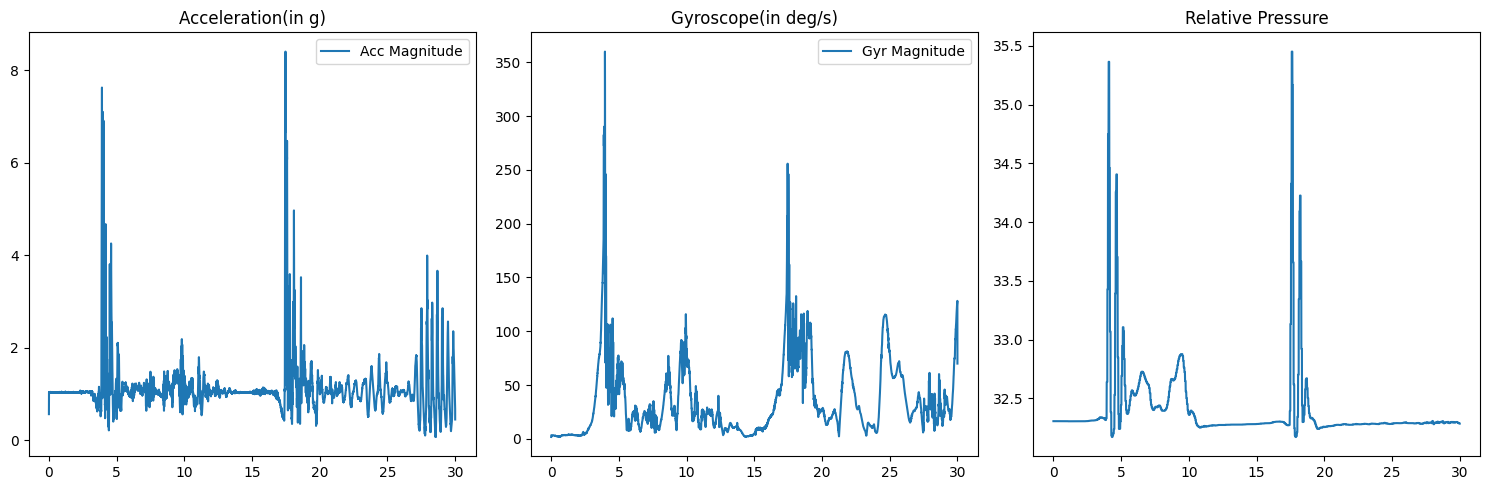

array([<Axes: title={'center': 'Acceleration(in g)'}>,
       <Axes: title={'center': 'Gyroscope(in deg/s)'}>,
       <Axes: title={'center': 'Relative Pressure'}>], dtype=object)

In [ ]:
average_plot_new(all_data,0,30,11,True)

## Plot moving average between 0s and 30s with label marking

In [ ]:
t=all_data['time']
acc_x=all_data['acc_x']
acc_y=all_data['acc_y']
acc_z=all_data['acc_z']

gyr_x=all_data['gyr_x']
gyr_y=all_data['gyr_y']
gyr_z=all_data['gyr_z']

pressure = all_data['pressure']

In [ ]:
## Find the moving average of acceleration and rotation
window_size = 21

#find the magnitude of acceleration and gyroscope measurement
acc = moving_average(find_absolute(acc_x,acc_y,acc_z),window_size)
gyr = moving_average(find_absolute(gyr_x,gyr_y,gyr_z),window_size)

3435660
3435660


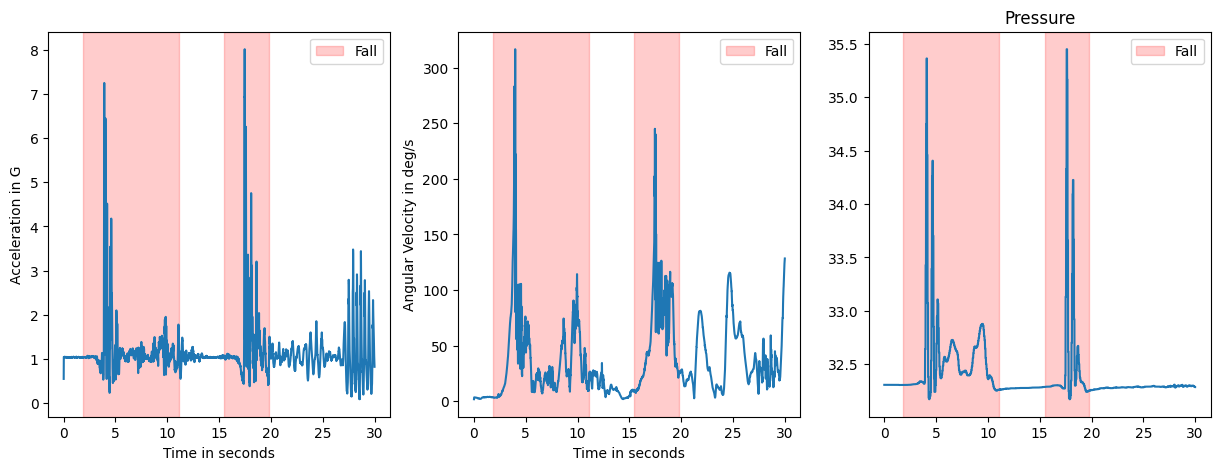

In [ ]:
#define plot time
t1 = 0
t2 = 30

print(len(acc))
print(len(t))
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_and_label(axs[0],t,acc,t1,t2,' ',data_labels)
axs[0].set_xlabel('Time in seconds')
axs[0].set_ylabel('Acceleration in G')
plot_and_label(axs[1],t,gyr,t1,t2,' ',data_labels)
axs[1].set_ylabel('Angular Velocity in deg/s')
axs[1].set_xlabel('Time in seconds')
plot_and_label(axs[2],t,pressure,t1,t2,'Pressure',data_labels)

In [ ]:
print(all_data.keys())
print(data_labels)

dict_keys(['time', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'pressure', 'label'])
[[1.8469996, 11.0831785, 'HitAndFalling'], [15.488411, 19.771484, 'HitAndFalling'], [33.608837, 35.868523, 'HitAndFalling'], [59.03365, 63.73295, 'HitAndFalling'], [84.13087, 87.12158, 'HitAndFalling'], [100.281204, 103.35899, 'HitAndFalling'], [127.32622, 130.60764, 'HitAndFalling'], [133.11852, 135.13042, 'HitAndFalling'], [149.67082, 152.33937, 'HitAndFalling'], [156.26337, 160.38582, 'HitAndFalling'], [169.21152, 171.90038, 'HitAndFalling'], [187.77809, 190.05026, 'HitAndFalling'], [212.4032025, 215.252945, 'HitAndFalling'], [227.33222899999998, 230.09200099999998, 'HitAndFalling'], [238.238095, 240.891579, 'HitAndFalling'], [247.487977, 251.248974, 'HitAndFalling'], [264.35321899999997, 271.13140899999996, 'HitAndFalling'], [281.606629, 284.676484, 'HitAndFalling'], [288.811739, 291.092589, 'HitAndFalling'], [299.192329, 302.567399, 'HitAndFalling'], [312.02583400000003, 316.272065, 'Hit